In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

In [2]:
DATA_PATH = Path("Dataset2.csv")  # adjust if needed
df = pd.read_csv(DATA_PATH)

def to_snake(s):
    return (str(s).strip()
            .replace(" ", "_").replace("-", "_").replace("/", "_").replace(".", "_")
            .lower())

df.columns = [to_snake(c) for c in df.columns]
df["enddate"] = pd.to_datetime(df["enddate"], errors="coerce")

In [3]:
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(dt) for dt in df.dtypes],
    "non_null": df.notna().sum().values,
    "nulls": df.isna().sum().values,
    "unique": [df[c].nunique(dropna=True) for c in df.columns],
})
schema.to_csv("data_dictionary.csv", index=False)
schema.head(20)

,column,dtype,non_null,nulls,unique
0,stock,object,17511,0,4422
1,enddate,datetime64[ns],17511,0,255
2,accountspayable,float64,16415,1096,14819
3,inventory,float64,9640,7871,8867
4,longtermdebt,float64,11222,6289,10746
5,netreceivables,float64,14544,2967,13691
6,nettangibleassets,float64,17351,160,17089
7,longterminvestments,float64,7499,10012,6874
8,totalcurrentassets,float64,17331,180,16999
9,propertyplantequipment,float64,15768,1743,14905


In [4]:
df = (df
      .drop_duplicates(subset=["stock", "enddate"])
      .sort_values(["stock", "enddate"])
      .reset_index(drop=True))
df.shape

(17511, 31)

In [5]:
to_float = lambda s: pd.to_numeric(df[s], errors="coerce").astype(float)

assets  = to_float("totalassets")
liab    = to_float("totalliab")
equity  = to_float("totalstockholderequity")
c_assets= to_float("totalcurrentassets")
c_liab  = to_float("totalcurrentliabilities")
inv     = to_float("inventory")
cash    = to_float("cash")
recv    = to_float("netreceivables")
ppe     = to_float("propertyplantequipment")
intang  = to_float("intangibleassets")
re      = to_float("retainedearnings")

def safe_div(n, d):
    return np.where((d==0) | pd.isna(d), np.nan, n/d)

In [6]:
df["year"] = df["enddate"].dt.year

df["leverage"]                     = safe_div(liab, assets)
df["equity_to_assets"]             = safe_div(equity, assets)
df["current_ratio"]                = safe_div(c_assets, c_liab)
df["quick_ratio"]                  = safe_div(c_assets - inv, c_liab)
df["wc_to_assets"]                 = safe_div(c_assets - c_liab, assets)
df["cash_to_assets"]               = safe_div(cash, assets)
df["receivables_to_assets"]        = safe_div(recv, assets)
df["inventory_to_assets"]          = safe_div(inv, assets)
df["ppe_to_assets"]                = safe_div(ppe, assets)
df["intangibles_to_assets"]        = safe_div(intang, assets)
df["retained_earnings_to_assets"]  = safe_div(re, assets)

In [7]:
# Key: use fill_method=None to avoid deprecated default behavior
df["asset_growth"] = (
    df.groupby("stock", sort=True)["totalassets"]
      .pct_change(fill_method=None)
      .astype(float)
)


In [8]:
metrics = [
    "leverage","equity_to_assets","current_ratio","quick_ratio","wc_to_assets",
    "cash_to_assets","receivables_to_assets","inventory_to_assets","ppe_to_assets",
    "intangibles_to_assets","retained_earnings_to_assets","asset_growth"
]

wins = df.copy()
for m in metrics:
    s = pd.to_numeric(wins[m], errors="coerce")
    lo, hi = np.nanpercentile(s.dropna(), [1, 99])
    wins[m] = s.clip(lo, hi)

wins.shape


(17511, 44)

In [9]:
summary = wins[metrics].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
summary["non_null"] = wins[metrics].notna().sum().values
summary.to_csv("summary_stats.csv")
corr = wins[metrics].corr(method="pearson", min_periods=100)
corr.to_csv("correlation_matrix.csv")
summary.head(12), corr.round(2)

(                               count      mean       std        min         1%        5%       25%       50%       75%        95%        99%        max  non_null
 leverage                     17315.0  0.580853  0.334966   0.017042   0.017046  0.102214  0.353801  0.560314  0.783372   1.037811   2.093732   2.094994     17315
 equity_to_assets             17339.0  0.350301  0.484453  -2.489655  -2.489338 -0.259357  0.169204  0.404006  0.623899   0.889094   0.984621   0.984708     17339
 current_ratio                17305.0  3.162214  4.758293   0.025990   0.025991  0.059886  0.951008  1.734745  3.247870  11.260169  32.490399  32.490905     17305
 quick_ratio                   9636.0  1.657489  1.730533   0.025098   0.025104  0.047007  0.650344  1.177431  1.987166   5.284532   9.879481   9.887085      9636
 wc_to_assets                 17305.0  0.135523  0.406611  -0.864855  -0.864845 -0.791558 -0.006425  0.122942  0.367928   0.807012   0.929759   0.929768     17305
 cash_to_assets       

In [12]:
wins.to_csv("Dataset2_cleaned.csv", index=False)

In [13]:
import matplotlib.pyplot as plt
Path("figures").mkdir(exist_ok=True)

plt.figure()
wins["leverage"].dropna().plot(kind="hist", bins=50, title="Distribution of Leverage (Debt/Assets)")
plt.xlabel("Leverage (Debt/Assets)")
plt.savefig("figures/hist_leverage.png", bbox_inches="tight")
plt.close()

plt.figure()
wins["asset_growth"].dropna().plot(kind="hist", bins=50, title="Distribution of Asset Growth (YoY)")
plt.xlabel("Asset Growth (YoY)")
plt.savefig("figures/hist_asset_growth.png", bbox_inches="tight")
plt.close()

avg_lev = wins.groupby("year", as_index=True)["leverage"].mean()
plt.figure()
avg_lev.plot(kind="line", marker="o", title="Average Leverage by Year")
plt.xlabel("Year"); plt.ylabel("Average Leverage")
plt.savefig("figures/avg_leverage_by_year.png", bbox_inches="tight")
plt.close()

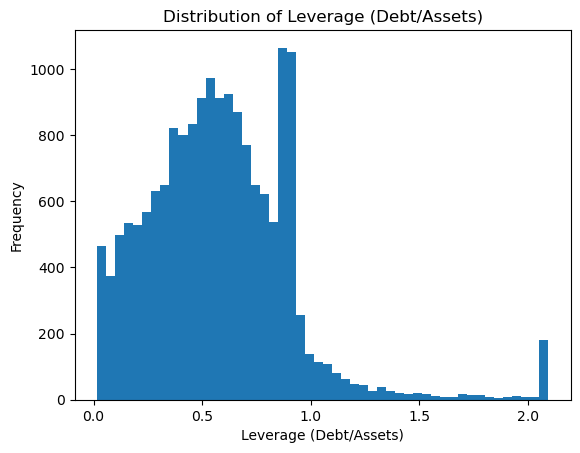

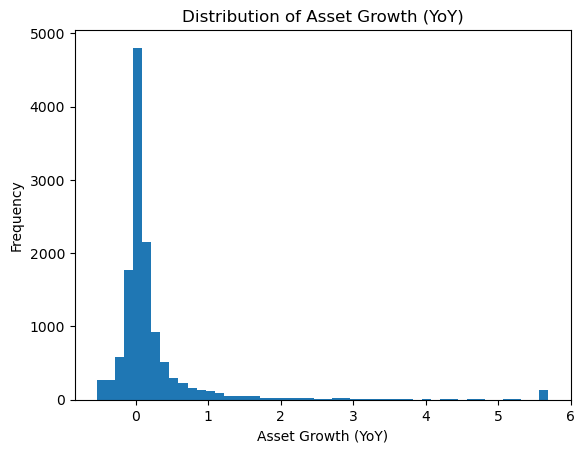

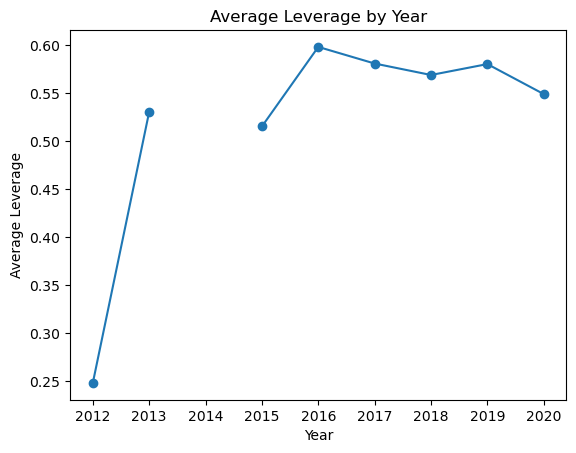

In [14]:
import matplotlib.pyplot as plt
from pathlib import Path

Path("figures").mkdir(exist_ok=True)

# Histogram: Leverage
plt.figure()
wins["leverage"].dropna().plot(kind="hist", bins=50, title="Distribution of Leverage (Debt/Assets)")
plt.xlabel("Leverage (Debt/Assets)")
plt.savefig("figures/hist_leverage.png", bbox_inches="tight")
plt.show()   # 👈 displays in notebook

# Histogram: Asset Growth
plt.figure()
wins["asset_growth"].dropna().plot(kind="hist", bins=50, title="Distribution of Asset Growth (YoY)")
plt.xlabel("Asset Growth (YoY)")
plt.savefig("figures/hist_asset_growth.png", bbox_inches="tight")
plt.show()

# Trend: Average Leverage by Year
avg_lev = wins.groupby("year", as_index=True)["leverage"].mean()
plt.figure()
avg_lev.plot(kind="line", marker="o", title="Average Leverage by Year")
plt.xlabel("Year"); plt.ylabel("Average Leverage")
plt.savefig("figures/avg_leverage_by_year.png", bbox_inches="tight")
plt.show()
